# Telco Customer Churn – Full Modeling Pipeline
This notebook includes:
- Data loading & cleaning
- Feature engineering
- Baseline models (LogReg, KNN, SVM)
- ROC curves & ROC-AUC
- GridSearchCV tuning (KNN & SVM)
- Threshold tuning
- Reflection answers

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, classification_report,
    confusion_matrix
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

pd.set_option('display.max_columns', None)


## 🔍 Exploratory Data Analysis (EDA)
This section explores the structure, distribution, and relationships within the Telco Customer Churn dataset.

### 1. Dataset Overview

In [2]:

df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.drop(columns="customerID", inplace=True)
df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 2. Summary Statistics

In [3]:

df.describe(include='all')


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043
unique,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,6531,2
top,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,,No
freq,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


In [4]:
df.dtypes.head(30)

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

### 4. Distribution of Numerical Variables

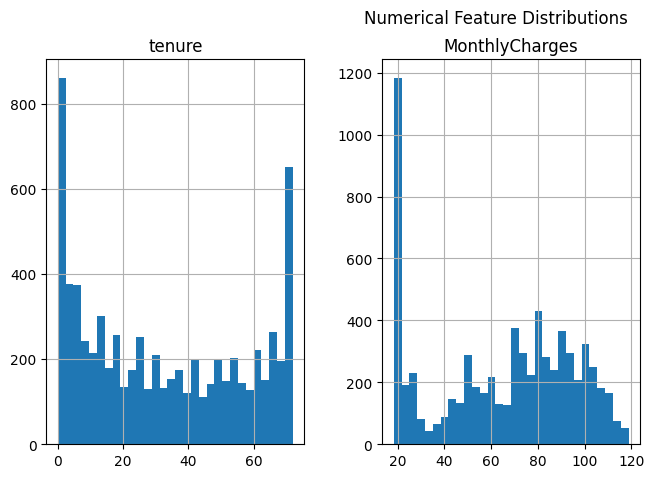

In [5]:

numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numeric_cols].hist(bins=30, figsize=(12,5), layout=(1,3))
plt.suptitle('Numerical Feature Distributions')
plt.show()


### 5. Boxplots for Outlier Detection

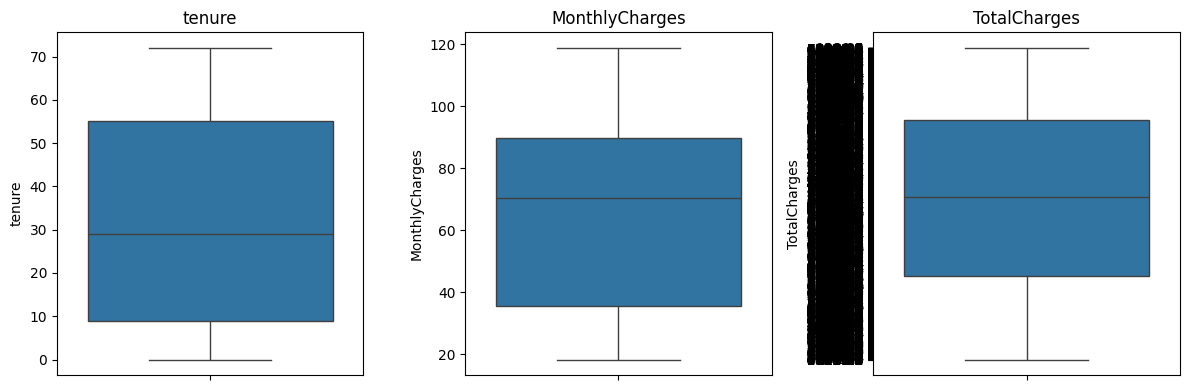

In [6]:

plt.figure(figsize=(12,4))
for i, col in enumerate(numeric_cols):
    plt.subplot(1,3,i+1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


### 6. Categorical Variable Counts

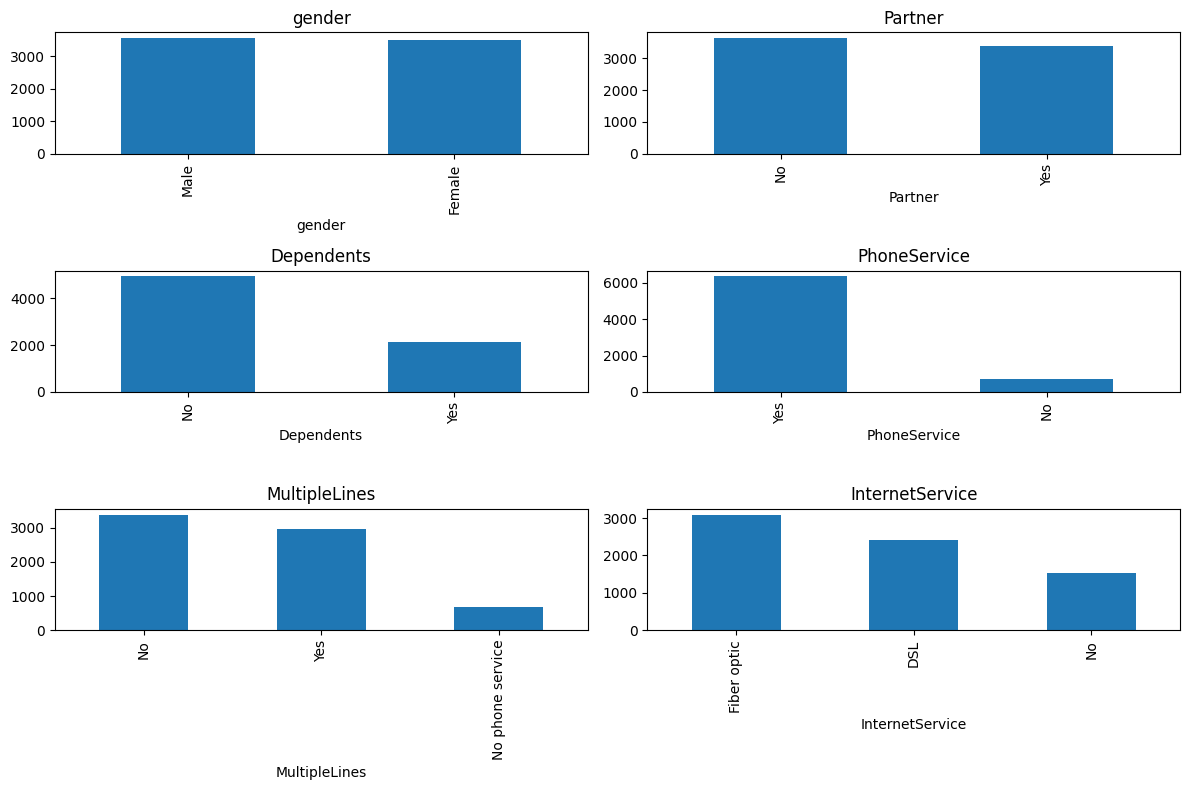

In [7]:

categorical_cols = df.select_dtypes(include='object').columns.tolist()
plt.figure(figsize=(12,8))
for i, col in enumerate(categorical_cols[:6]):
    plt.subplot(3,2,i+1)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
plt.tight_layout()
plt.show()


### 7. Churn vs Categorical Features

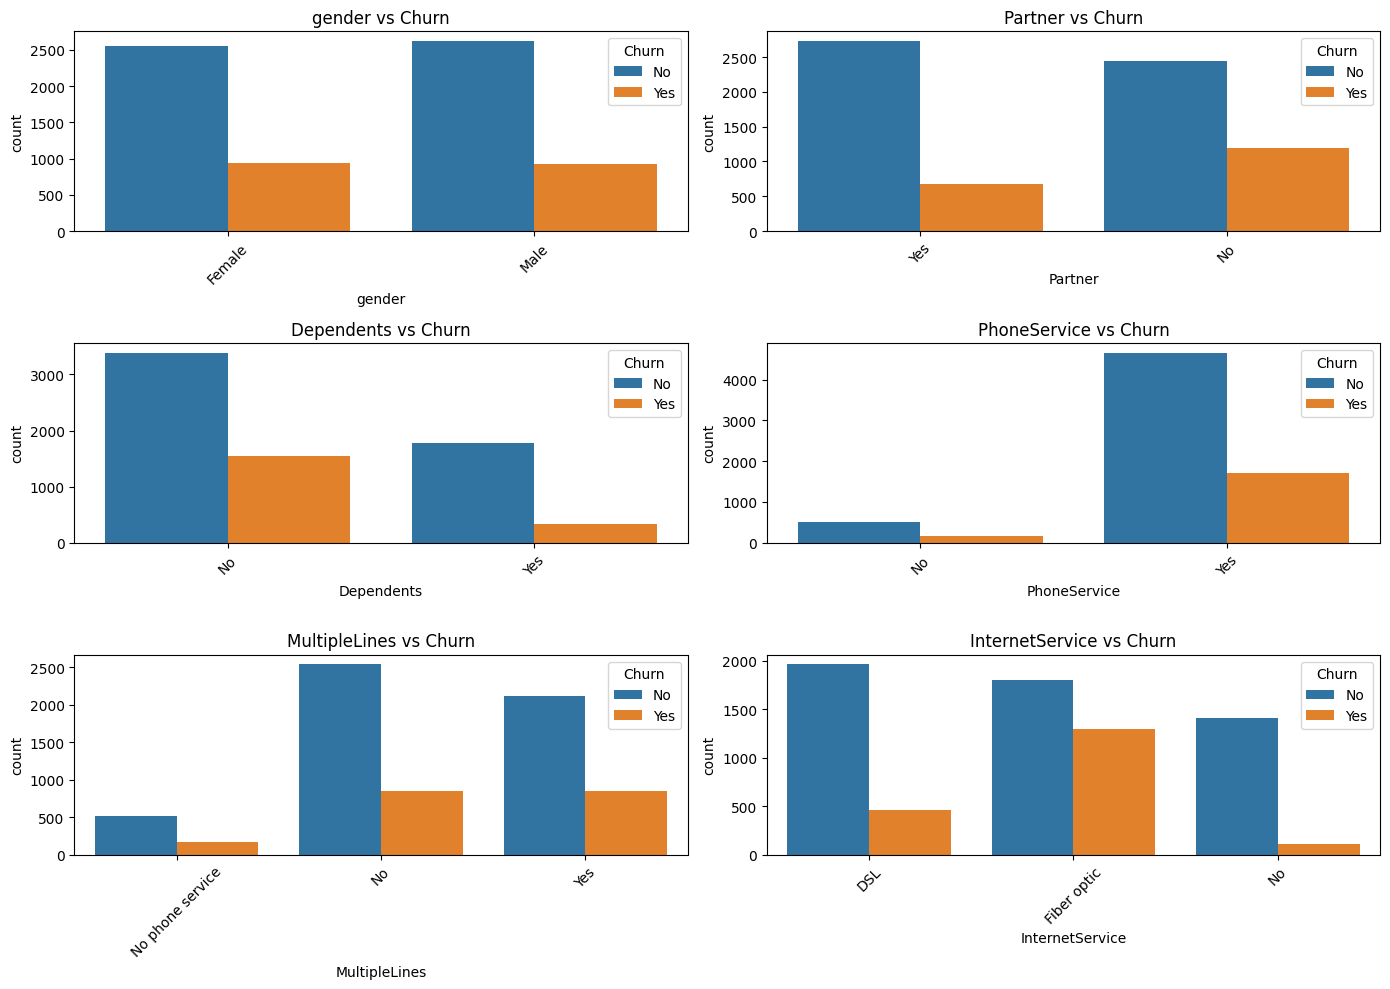

In [8]:

plt.figure(figsize=(14,10))
for i, col in enumerate(categorical_cols[:6]):
    plt.subplot(3,2,i+1)
    sns.countplot(data=df, x=col, hue='Churn')
    plt.xticks(rotation=45)
    plt.title(f"{col} vs Churn")
plt.tight_layout()
plt.show()


### 8. Correlation Heatmap

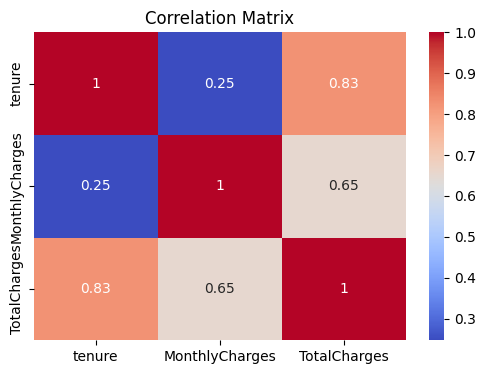

In [9]:

df_corr = df.copy()
df_corr['TotalCharges'] = pd.to_numeric(df_corr['TotalCharges'], errors='coerce')
numeric_df = df_corr[['tenure','MonthlyCharges','TotalCharges']].dropna()

plt.figure(figsize=(6,4))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


## Load Dataset

## Cleaning

In [10]:

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df['SeniorCitizen'] = df['SeniorCitizen'].astype(int)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 


In [11]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0
7028,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0
7029,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0
7030,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,1


## Feature Engineering

In [12]:

contract_map = {'Month-to-month': 1, 'One year': 12, 'Two year': 24}
df['ContractMonths'] = df['Contract'].map(contract_map)
df['TenureYears'] = df['tenure'] / 12
df['RemainingContractMonths'] = (df['ContractMonths'] - df['tenure']).clip(lower=0)
df['RemainingContractYears'] = df['RemainingContractMonths'] / 12
df['Tenure_Monthly_Interaction'] = df['tenure'] * df['MonthlyCharges']
df['Remaining_Monthly_Interaction'] = df['RemainingContractMonths'] * df['MonthlyCharges']
df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ContractMonths,TenureYears,RemainingContractMonths,RemainingContractYears,Tenure_Monthly_Interaction,Remaining_Monthly_Interaction
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,1,0.083333,0,0.0,29.85,0.0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,12,2.833333,0,0.0,1936.30,0.0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,1,0.166667,0,0.0,107.70,0.0
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,12,3.750000,0,0.0,1903.50,0.0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,1,0.166667,0,0.0,141.40,0.0


## Preprocessing

In [13]:

X = df.drop(columns= ['Churn'])
y = df['Churn']

categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

preprocess = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape


((5625, 25), (1407, 25))

## Baseline Models

In [14]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM (RBF)": SVC(kernel='rbf', probability=True)
}

results = []
probas = {}

for name, clf in models.items():
    pipe = Pipeline([('preprocess', preprocess), ('model', clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    probas[name] = y_proba

    results.append({
        'model': name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    })

pd.DataFrame(results)


,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.802416,0.646341,0.566845,0.603989,0.834834
1,KNN,0.759062,0.545220,0.564171,0.554534,0.776753
2,SVM (RBF),0.788913,0.638989,0.473262,0.543779,0.781946


## ROC Curves

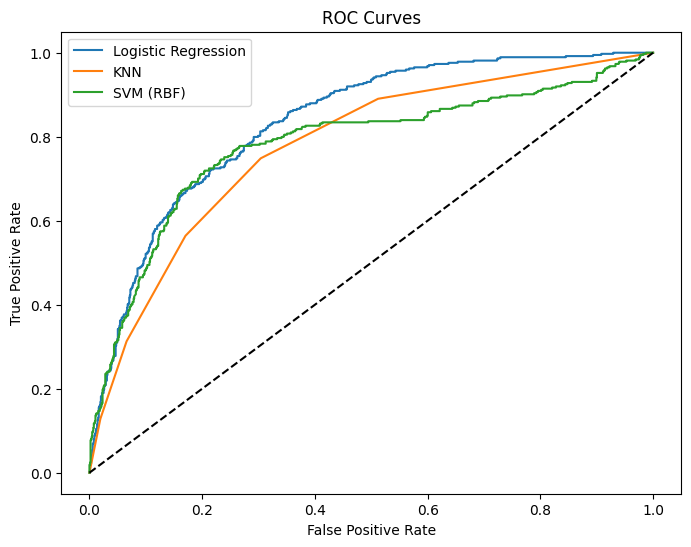

In [15]:

plt.figure(figsize=(8,6))
for name, y_proba in probas.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


## GridSearchCV Tuning

In [ ]:

# KNN tuning
knn_grid = {
    'model__n_neighbors': [3,5,7,9,11,13,15]
}
knn_pipe = Pipeline([('preprocess', preprocess),
                     ('model', KNeighborsClassifier())])
knn_search = GridSearchCV(knn_pipe, knn_grid, scoring='f1', cv=5, n_jobs=-1)
knn_search.fit(X_train, y_train)

# SVM tuning
svm_grid = {
    'model__kernel': ['linear','rbf','poly'],
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__gamma': ['scale','auto',0.01,0.001]
}
svm_pipe = Pipeline([('preprocess', preprocess),
                     ('model', SVC(probability=True))])
svm_search = GridSearchCV(svm_pipe, svm_grid, scoring='f1', cv=5, n_jobs=-1)
svm_search.fit(X_train, y_train)

knn_search.best_params_, svm_search.best_params_


({'model__n_neighbors': 15},
 {'model__C': 100, 'model__gamma': 'scale', 'model__kernel': 'linear'})

## Evaluate Tuned Models

In [17]:

tuned_results = []

for name, search in [("KNN Tuned", knn_search), ("SVM Tuned", svm_search)]:
    best = search.best_estimator_
    y_pred = best.predict(X_test)
    y_proba = best.predict_proba(X_test)[:,1]
    tuned_results.append({
        'model': name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    })

pd.DataFrame(tuned_results)


,model,accuracy,precision,recall,f1,roc_auc
0,KNN Tuned,0.776830,0.582873,0.564171,0.573370,0.813681
1,SVM Tuned,0.800284,0.647619,0.545455,0.592163,0.825563


## Threshold Tuning

In [18]:

best_search = max([svm_search, knn_search], key=lambda s: s.best_score_)
best_model = best_search.best_estimator_

y_proba = best_model.predict_proba(X_test)[:,1]
thresholds = np.arange(0.1, 0.91, 0.05)

tuning = []
for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    tuning.append([t,
                   f1_score(y_test, y_pred_t),
                   recall_score(y_test, y_pred_t)])
tuning_df = pd.DataFrame(tuning, columns=['threshold','f1','recall'])
tuning_df


,threshold,f1,recall
0,0.10,0.529811,0.938503
1,0.15,0.576096,0.895722
2,0.20,0.601345,0.836898
3,0.25,0.618378,0.764706
4,0.30,0.614486,0.703209
5,0.35,0.619403,0.665775
6,0.40,0.608579,0.606952
7,0.45,0.597734,0.564171
8,0.50,0.580741,0.524064
9,0.55,0.540625,0.462567


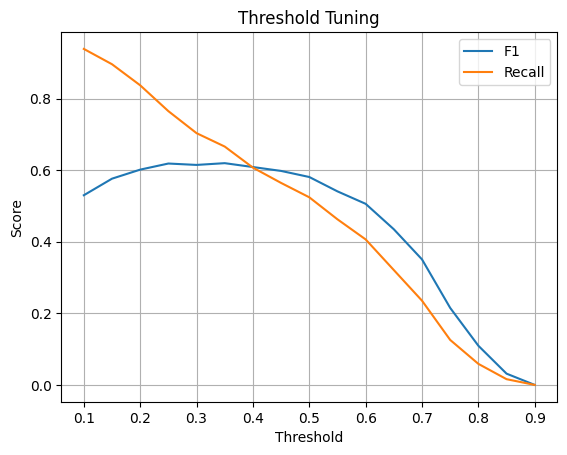

In [19]:

plt.plot(tuning_df['threshold'], tuning_df['f1'], label='F1')
plt.plot(tuning_df['threshold'], tuning_df['recall'], label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning")
plt.legend()
plt.grid()
plt.show()
